<a href="https://colab.research.google.com/github/fernando-RA/fastaiOnCampus/blob/a01/Article01_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Fernando Ribeiro Aguilar: 14/0139281

# Using FastAi vision to predict Aesthetic Genres

This is a technical article that describes how to use fastAi to make aesthetic genre predictions.


# Introduction
The word "aesthetic" originated as the philosophical discussion about what beauty is, how we should approach it, and why it exists. 

Later, the academic field of art history used aesthetic to refer to a set of principles motivating artists and certain periods of art history.

Aesthetics have now means a collection of images, colors, objects, music, and writings that creates a specific emotion, purpose, and narrative.


## Technical Details

In this section, we'll describe how to use machine learning to make aesthetic genre predictions.


### Downloading and importing dependencies, 

note that we will use fastai sdk models and duckduckgo to search


In [1]:
!pip install -Uqq fastai duckduckgo_search fastbook

     |████████████████████████████████| 240 kB 5.1 MB/s 
     |████████████████████████████████| 719 kB 58.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 96 kB 5.5 MB/s 
     |████████████████████████████████| 441 kB 59.9 MB/s 
     |████████████████████████████████| 5.5 MB 56.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 1.6 MB 52.9 MB/s 
     |████████████████████████████████| 212 kB 60.8 MB/s 
     |████████████████████████████████| 95 kB 4.0 MB/s 
     |████████████████████████████████| 163 kB 51.2 MB/s 
     |████████████████████████████████| 115 kB 15.3 MB/s 
     |████████████████████████████████| 127 kB 77.0 MB/s 
     |████████████████████████████████| 115 kB 12.4 MB/s 
     |████████████████████████████████| 7.6 MB 46.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source o

In [2]:
import os
from fastai.vision.all import *
from fastbook import *

###  Downloading images

Here we create a new folder for each label and download 200*3 images for training purpose,


In [3]:
aesthetic_labels = ['cyberpunk', 'solarpunk', 'lunarpunk']
folder_path = Path('aesthetics')

for label in aesthetic_labels:
    destination = (folder_path/label)
    destination.mkdir(exist_ok=True, parents=True)
    download_images(destination, urls=search_images_ddg(label, max_images=200))


### Cleaning up

Then we clean up the images that couldn't be downloaded properly

In [4]:

corrupt_images = verify_images(get_image_files(folder_path))
corrupt_images.map(Path.unlink)
total_corrupted = len(corrupt_images)
print('Amount of corrupted image files removed:')
print(total_corrupted)

Amount of corrupted image files removed:
89


### Creating a Datablock

A datablock is a High level API to quickly get your data in a DataLoaders

This allows the data to be loaded into memory which makes it easier and faster for the gpu to access in the training phase

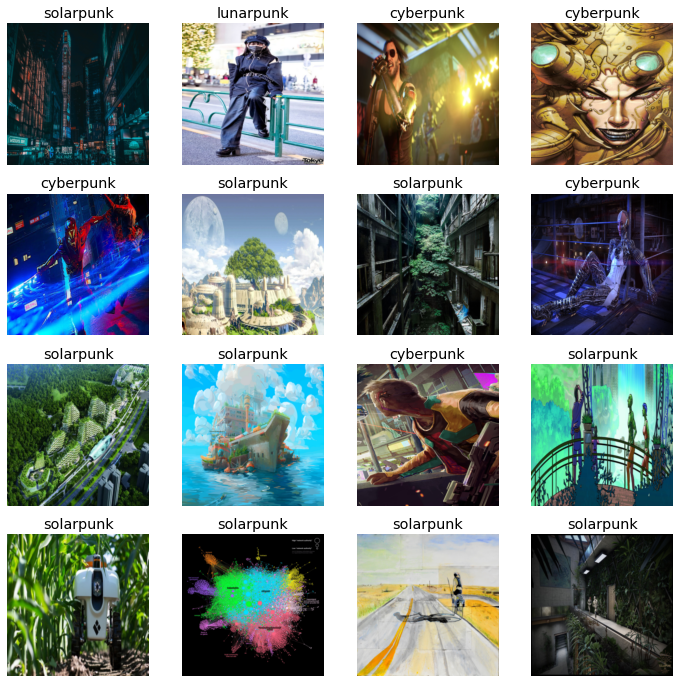

In [5]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(folder_path, bs=70)

datablock.show_batch(max_n=16)

## Training

The [vision_learner](https://docs.fast.ai/vision.learner.html#vision_learner) function will help us define a Learner using a pretrained model.

We then fine tune the Learner with our datablock to improve its prediction accuracy.

Here I've decided to use resnet50 as our model. 

I wanted to run the resnet152 but 15gb of memory in my GPU was not enough. Same for resnet101.

Resnet models were proposed in “Deep Residual Learning for Image Recognition”.

This is the architecture for resnets. [source](https://pytorch.org/assets/images/resnet.png) 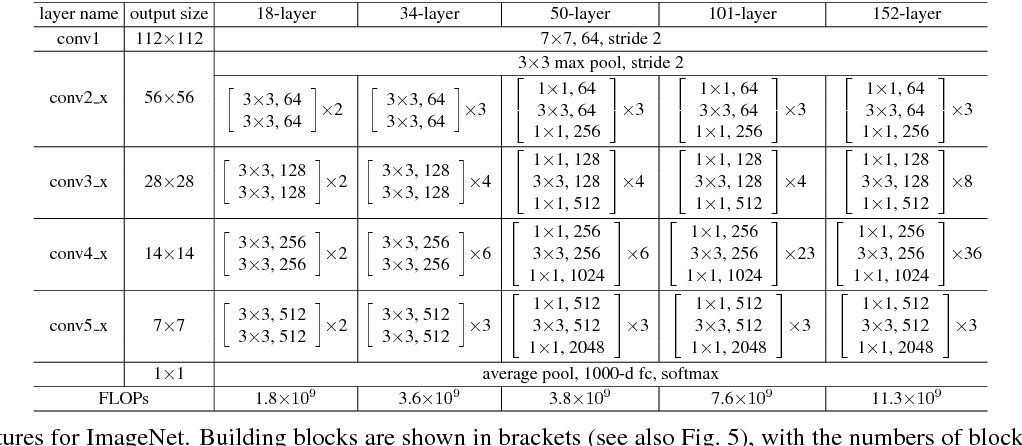

If you do not select a loss or optimizer function, fastai will try to choose the best selection for the task. Here I've set it to `CrossEntropyLossFlat` For the optimizer I've decided to let it choose the best one for us.

In [6]:
learn = vision_learner(datablock, resnet50, metrics=accuracy, loss_func=CrossEntropyLossFlat())
learn.fine_tune(16)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.358495,4.160982,0.463415,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.483751,1.593604,0.621951,00:21
1,0.330354,0.897100,0.731707,00:22
2,0.256003,0.623839,0.792683,00:21
3,0.203926,0.575800,0.841463,00:24
4,0.176167,0.692440,0.829268,00:22
5,0.155981,0.686741,0.829268,00:21
6,0.137672,0.545401,0.865854,00:24
7,0.125522,0.493648,0.878049,00:23
8,0.117793,0.497654,0.878049,00:22
9,0.111472,0.492705,0.865854,00:21


### Testing our Data

Now we download some previous labeled images, and run our model against them to make a prediction.

We do this for all three labels.

In [8]:
from fastdownload import download_url
import re

regex_pattern = r'^(.*[\\\/])'
assert_against = {
    'cyberpunk': 'https://static.wikia.nocookie.net/aesthetics/images/2/2e/1022371.jpg',
    'solarpunk': 'https://static.wikia.nocookie.net/aesthetics/images/d/d2/Chobani_Ad_1.png',
    'lunarpunk': 'https://static.wikia.nocookie.net/aesthetics/images/2/2c/Lunarpunk4.jpg'
}

sample_path = Path('sample_data')

for label in aesthetic_labels:
    test_destination = (sample_path/label)
    test_destination.mkdir(exist_ok=True, parents=True)
    download_url(assert_against[label], '', show_progress=True)
    file_name = re.sub(regex_pattern, '', assert_against[label])
    result,_,probs = learn.predict(PILImage.create(file_name))
    print(f"Correct label: {label},  ML Prediction: {result}.")
    print(f"Probabilities: Cyberpunk: {probs[0]:.4f}, Solarpunk: {probs[2]:.4f}, Lunarpunk: {probs[1]:.4f}")


Correct label: cyberpunk,  ML Prediction: cyberpunk.
Probabilities: Cyberpunk: 1.0000, Solarpunk: 0.0000, Lunarpunk: 0.0000


Correct label: solarpunk,  ML Prediction: solarpunk.
Probabilities: Cyberpunk: 0.0000, Solarpunk: 0.9997, Lunarpunk: 0.0003


Correct label: lunarpunk,  ML Prediction: lunarpunk.
Probabilities: Cyberpunk: 0.0000, Solarpunk: 0.0104, Lunarpunk: 0.9895


### Results

The results are being predicted correctly. We tried 3 predictions and got them all right.

Our current model has a slight chance of being overfitted. When I've trained it with resnet34 and batchsize 6, the accuracy was more than 90%. Using resnet50 the accuracy is 0.878049



### Conclusion

FastAI makes it easy to deploy a model with minimal coding. Our solution could be better architected for usage of hyperparameters. 

Overall the results are satisfactory